In [1]:
# imports cell
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import warnings

# to create a tensor on the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

In [2]:
filename = "./dataset/icml_face_data.csv"

emotions = ['Angry',  'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise', 'Neutral']

In [3]:
dataset_df = pd.read_csv(filename)
dataset_df

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [4]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels and pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 1, 48 * 48))
    image_label = np.array(list(map(int, data['emotion']))).reshape(len(data), 1)

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (1, 48 * 48))
        image_array[i] = image

    return image_array, image_label

In [5]:
x_train, y_train = prepare_data(dataset_df[dataset_df[' Usage'] == 'Training'])
x_val, y_val = prepare_data(dataset_df[dataset_df[' Usage'] == 'PrivateTest'])
x_test, y_test = prepare_data(dataset_df[dataset_df[' Usage'] == 'PublicTest'])

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((28709, 1, 2304),
 (28709, 1),
 (3589, 1, 2304),
 (3589, 1),
 (3589, 1, 2304),
 (3589, 1))

In [7]:
le = OneHotEncoder()
y_train = le.fit_transform(y_train).toarray()
y_val = le.fit_transform(y_val).toarray()
y_test = le.fit_transform(y_test).toarray()
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [8]:
class MyDataset(Dataset):
    def __init__(self, array, labels):
        self.array = array
        self.labels = labels

    def __getitem__(self, index):
        return torch.tensor(self.array[index], dtype=torch.float32, device=device), torch.tensor(self.labels[index],
                                                                                                 dtype=torch.float32,
                                                                                                 device=device)

    def __len__(self):
        return len(self.array)

In [9]:
trainDataset = MyDataset(x_train, y_train)

train_dataloader = DataLoader(trainDataset, batch_size=128, shuffle=True)

In [10]:
valDataset = MyDataset(x_val, y_val)

val_dataloader = DataLoader(valDataset, batch_size=128, shuffle=True)

In [11]:
testDataset = MyDataset(x_test, y_test)

test_dataloader = DataLoader(testDataset, batch_size=128, shuffle=True)

In [12]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # output size : (width - filter + 2*padding)/stride +1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=7, stride=1, padding=3)
        torch.nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('relu'))

        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('relu'))

        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv3.weight, gain=nn.init.calculate_gain('relu'))

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(73728, 1024)  # dim c * w * h
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

        self.fc2 = nn.Linear(1024, 7)
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, data):
        data = self.conv1(data)
        data = F.relu(data)
        data = self.conv2(data)
        data = F.relu(data)
        data = F.max_pool1d(data,1)
        data = self.conv3(data)
        data = F.relu(data)
        data = torch.flatten(data, 1)
        data = self.fc1(data)
        data = F.relu(data)
        data = self.dropout(data)
        data = self.fc2(data)

        return data

In [13]:
def train_model(model, dataloader, optimizer):
    model.train()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    for (data, label) in dataloader:
        # reset gradients (it will accumulate gradients otherwise)
        optimizer.zero_grad()

        # forward pass
        output = model(data)

        # compute loss
        loss_ = loss(output, label)
        total_loss += loss_.item()

        # backward propagation dl/dw -> gradients
        loss_.backward()

        # update weights
        optimizer.step()

        ######################################

        _, predicted = torch.max(output.data, dim=1)
        _, true_label = torch.max(label, dim=1)
        pred += predicted.tolist()
        labels += true_label.tolist()

    return accuracy_score(labels, pred) * 100., total_loss / len(dataloader)

In [14]:
def test_model(model, dataloader):
    model.eval()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for (data, label) in dataloader:
            output = model(data)

            # compute loss
            loss_ = loss(output, label)
            total_loss += loss_.item()


            _, predicted = torch.max(output.data, dim=1)
            _, true_label = torch.max(label, dim=1)
            pred += predicted.tolist()
            labels += true_label.tolist()

    return labels, pred, accuracy_score(labels, pred) * 100., total_loss / len(dataloader)

In [15]:
model_path = "./cnn_model.pth"

model = CNN_Model().to(device)

#model.load_state_dict(torch.load(model_path_raw))

print('Number of Parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of Parameters :  75507703


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, threshold=0.001)


In [17]:
train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

In [18]:
epoch = 10

# Train and validate model

for e in range(epoch):
    train_accuracy, train_loss = train_model(model, train_dataloader, optimizer)

    val_labels, val_pred, val_accuracy, val_loss = test_model(model, val_dataloader)

    # Decay Learning Rate
    scheduler.step(val_loss)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

    print('epoch: ', e + 1, 'Training loss: ', train_loss, 'Training Accuracy: ', train_accuracy, '%', '  Val loss: ',
          val_loss, 'Val Accuracy: ', val_accuracy, '%')

    #print('learning rate :', optimizer.state_dict()['param_groups'][0]['lr'])


epoch:  1 Training loss:  557.1340120659934 Training Accuracy:  22.7594134243617 %   Val loss:  1.9097109128688943 Val Accuracy:  24.547227640011148 %
epoch:  2 Training loss:  1.8920396545198228 Training Accuracy:  25.215089344804763 %   Val loss:  1.8762149728577713 Val Accuracy:  24.435775982167733 %
epoch:  3 Training loss:  1.864295530319214 Training Accuracy:  25.17677383398934 %   Val loss:  1.8594662444344883 Val Accuracy:  24.463638896628588 %
epoch:  4 Training loss:  1.8456343958112928 Training Accuracy:  25.183740290501238 %   Val loss:  1.8419212308423272 Val Accuracy:  24.519364725550293 %
epoch:  5 Training loss:  1.8358038144641453 Training Accuracy:  25.173290605733396 %   Val loss:  1.842143494507362 Val Accuracy:  24.49150181108944 %
epoch:  6 Training loss:  1.8291816902160645 Training Accuracy:  25.201156431780973 %   Val loss:  1.8234833972207432 Val Accuracy:  24.519364725550293 %
epoch:  7 Training loss:  1.8221541007359823 Training Accuracy:  25.201156431780973

Test loss:  1.8173892374696403 Test Accuracy:  24.965171356923936 %


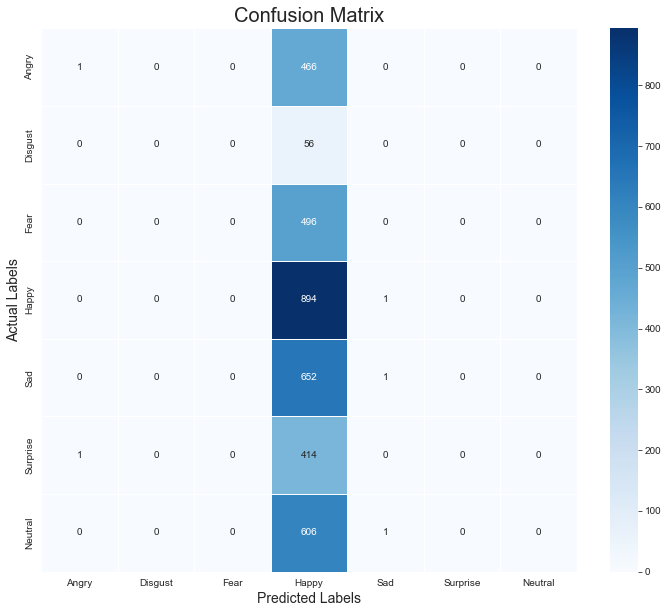

In [19]:
# test model

test_labels, test_pred, test_accuracy, test_loss = test_model(model, test_dataloader)
print('Test loss: ', test_loss, 'Test Accuracy: ', test_accuracy, '%')

cm = confusion_matrix(test_labels, test_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=emotions, columns=emotions)
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [20]:
#torch.save(model.state_dict(), model_path)

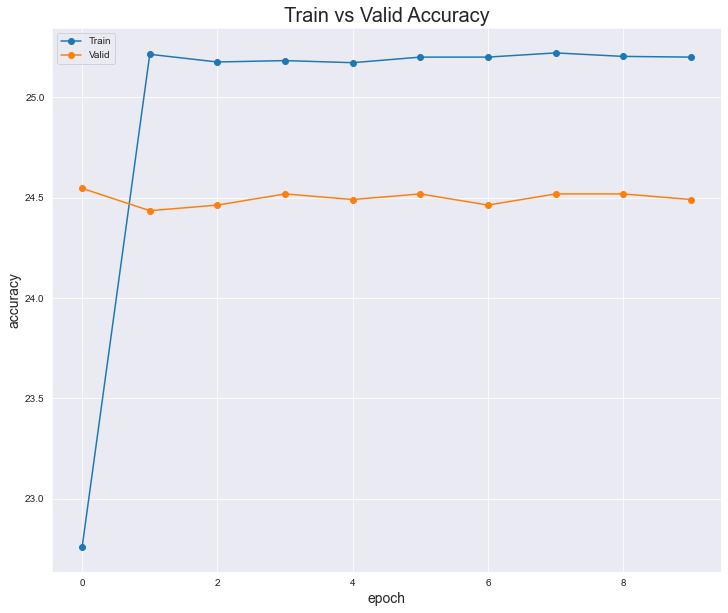

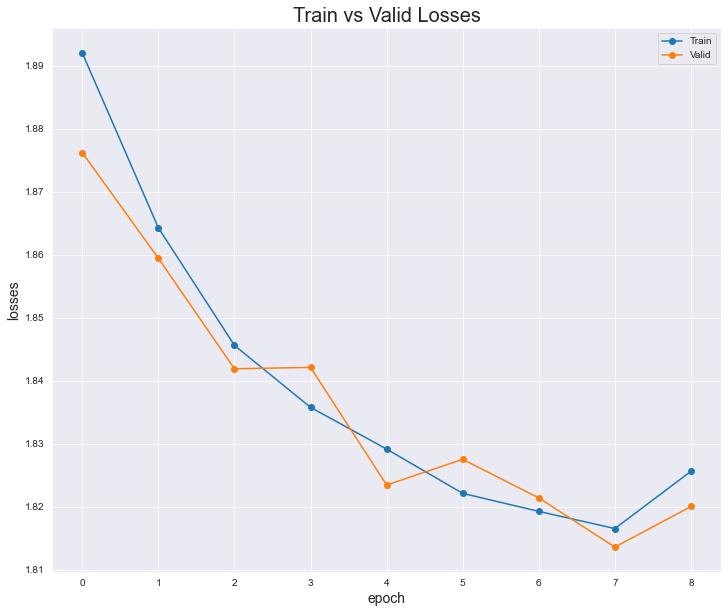

In [21]:
plt.figure(figsize=(12, 10))
plt.plot(train_acc_list, '-o')
plt.plot(val_acc_list, '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('accuracy', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy', size=20)

plt.show()

plt.figure(figsize=(12, 10))
plt.plot(train_loss_list[1:], '-o')
plt.plot(val_loss_list[1:], '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('losses', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses', size=20)

plt.show()